In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.style.use('dark_background')
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

# Splitting Train-Test data
from sklearn.model_selection import train_test_split

# For Cross Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# For showing Progress Bar
from tqdm.notebook import tqdm

# Models
import optuna
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

In [3]:
def outlier_viz(col):
    '''Distribution and Boxplot for Outlier Detection by @kartik2khandelwal'''
    import random
    color = random.choice(['r', 'g', 'b'])
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    sns.distplot(col, ax=ax[0], color=color)
    sns.boxplot(col, ax=ax[1], color=color)
    plt.suptitle('Distribution & Boxplot for Outlier Detection')
    fig.show()
    return None

def my_print(s):
    '''Custom print function by @kartik2khandelwal :)'''
    a = 4
    for i in s:
        a+=1
    return print('-' * a + '\n' + '| ' + s + ' |' + '\n' + '-' * a)

In [4]:
df = pd.read_csv('./Fraud.csv')

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


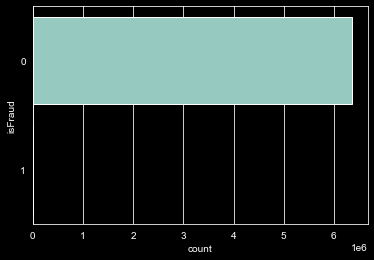

In [9]:
sns.countplot(y = df['isFraud']);

Target Variable is highly Imbalanced.

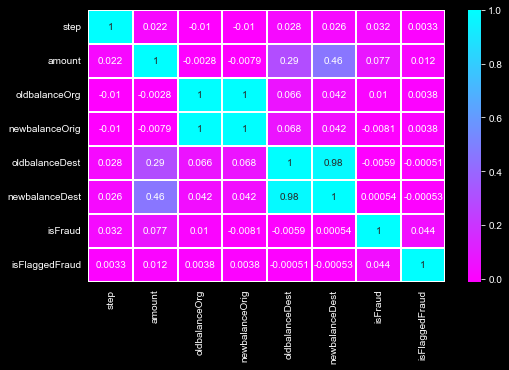

In [10]:
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(), cmap='cool_r', linewidth=0.2, annot=True);

In [11]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [12]:
fraud = df[df['isFraud'] == 1]

In [13]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Splitting Numerical and Categorical Data

In [14]:
cat = [i for i in df.drop('isFraud', axis=1).columns if df[i].dtypes == 'O']
cat

['type', 'nameOrig', 'nameDest']

In [15]:
num = [i for i in df.drop('isFraud', axis=1).columns if df[i].dtypes != 'O']
num

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFlaggedFraud']

Categorical Data

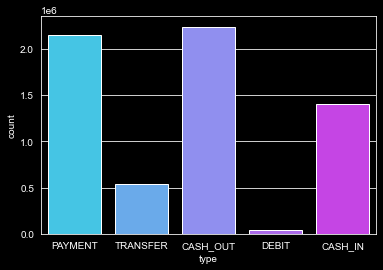

In [16]:
sns.countplot(df['type'], palette='cool');

In [17]:
df['nameOrig'].nunique(), df['nameDest'].nunique()

(6353307, 2722362)

<AxesSubplot:xlabel='step', ylabel='Density'>

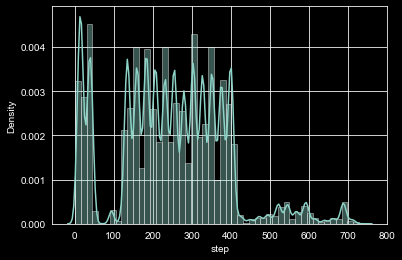

In [18]:
sns.distplot(df['step'])

<AxesSubplot:xlabel='amount', ylabel='Density'>

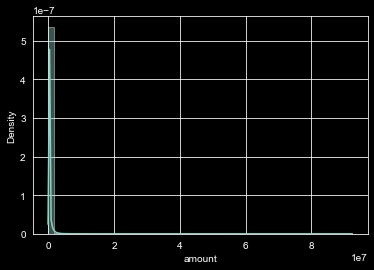

In [19]:
sns.distplot(df['amount'])

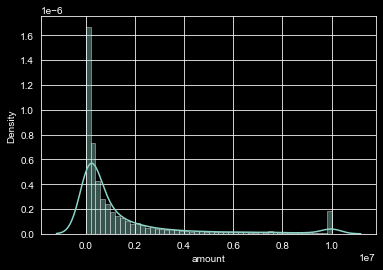

In [20]:
sns.distplot(fraud['amount']);

We can see that fraud is only when amount is low.

In [21]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [22]:
types = pd.get_dummies(df['type'], prefix='type', drop_first=True)
types.head()

,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,0,1,0
1,0,0,1,0
2,0,0,0,1
3,1,0,0,0
4,0,0,1,0


In [23]:
df['nameOrig'] = label.fit_transform(df['nameOrig'])
df['nameDest'] = label.fit_transform(df['nameDest'])

In [24]:
df[['nameOrig', 'nameDest']]

,nameOrig,nameDest
0,757869,1662094
1,2188998,1733924
2,1002156,439685
3,5828262,391696
4,3445981,828919
...,...,...
6362615,5651847,505863
6362616,1737278,260949
6362617,533958,108224
6362618,2252932,319713


In [25]:
df = pd.concat([df, types], axis=1)
df = df.drop('type', axis=1)
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0,0,0,1,0
2,1,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0,0,0,0,1
3,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0,0,0,1,0


In [26]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [27]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [28]:
N_SPLITS = 2  # previous:300, increasing N_SPLITS to remove error due to randomness

lgbm_preds = []
xgb_preds = []
catb_preds = []

prob = []

folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)

for fold, (train_id, test_id) in enumerate(tqdm(folds.split(X, y), total=N_SPLITS)):

    my_print(f'fold {fold + 1}')

    X_train, y_train = X.iloc[train_id], y.iloc[train_id] 
    X_valid, y_valid = X.iloc[test_id], y.iloc[test_id]
    
    lgbm_model = lgbm.LGBMClassifier()
    xgb_model  = xgb.XGBClassifier()
    catb_model = catb.CatBoostClassifier(verbose=0)
    
    lgbm_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)
    catb_model.fit(X_train, y_train)
        
    my_print(f'Training Accuracy   :- {(lgbm_model.score(X_train, y_train)*100).round(2)}% | {(xgb_model.score(X_train, y_train)*100).round(2)}% | {(catb_model.score(X_train, y_train)*100).round(2)}%')
    my_print(f'Validation Accuracy :- {(lgbm_model.score(X_valid, y_valid)*100).round(2)}% | {(xgb_model.score(X_valid, y_valid)*100).round(2)}% | {(catb_model.score(X_valid, y_valid)*100).round(2)}%')
    
    prob1, prob2, prob3 = lgbm_model.predict_proba(X_test), xgb_model.predict_proba(X_test), catb_model.predict_proba(X_test)
    prob.append((prob1 + prob2 + prob3) / 3)
my_print('Model Trained !!!')

  0%|          | 0/2 [00:00<?, ?it/s]

----------
| fold 1 |
----------
[06:59:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
---------------------------------------------------
| Training Accuracy   :- 99.51% | 99.99% | 100.0% |
---------------------------------------------------
--------------------------------------------------
| Validation Accuracy :- 99.5% | 99.98% | 99.97% |
--------------------------------------------------
----------
| fold 2 |
----------
[07:04:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
-----

In [29]:
final = [[0,0]]
for i in range(N_SPLITS):
    final = final + prob[i]
    
final = final/N_SPLITS
y_pred = pd.Series([np.argmax([i]) for i in final])

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix

my_print(f'Test Accuracy:- {accuracy_score(y_test, y_pred)*100}%')

-------------------------------------
| Test Accuracy:- 99.9748531265422% |
-------------------------------------


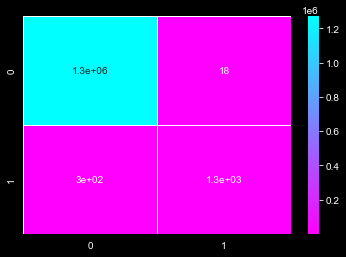

In [31]:
sns.heatmap(confusion_matrix(y_test, y_pred), cmap='cool_r', linewidths=0.5, annot=True);